# PLAsTICC: Astronomic Classification

This jupyter notebook was a project created by [@diana-fsa](https://github.com/diana-fsa)(github) at fourth year of college in 2022.

In [46]:
import pandas as pd
import seaborn as sns
sns.set_theme()
%matplotlib inline
from tqdm import tqdm
import numpy as np
import torch
import random
from tsfresh import extract_features
from tsfresh import feature_selection
from torch import nn

### Import data

In [66]:
training_set = pd.read_csv('./data/training_set.csv')
training_set_metadata = pd.read_csv('./data/training_set_metadata.csv')
extracted_features = pd.read_csv('./extracted_features.csv')

In [3]:
training_set

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1
...,...,...,...,...,...,...
1421700,130779836,60555.9838,4,-39.881969,46.477093,0
1421701,130779836,60560.0459,1,14.894439,18.947685,0
1421702,130779836,60571.0225,5,30.593130,50.695290,0
1421703,130779836,60585.9974,4,-23.471439,44.819859,0


In [4]:
training_set_metadata

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.718750,-14.940303,172.342697,-72.255675,0,0.0000,0.0000,0.0000,NaN,0.013,65
7844,130755807,120.101349,-62.696659,275.742955,-16.509746,0,0.1725,2.5606,1.1146,46.6108,0.136,90
7845,130762946,203.108109,-55.682144,308.728904,6.727511,0,0.0000,0.0000,0.0000,NaN,0.430,16
7846,130772921,79.101562,-35.501846,239.172243,-33.827844,0,0.0000,0.0000,0.0000,NaN,0.034,65


### Data exploration/visualization

#### Quick check of how many NaN data there is in both tables

In [5]:
training_set.isnull().sum(axis = 0)

object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64

In the training_set table we don't have that issue.

In [6]:
training_set_metadata.isnull().sum(axis = 0)

object_id                0
ra                       0
decl                     0
gal_l                    0
gal_b                    0
ddf                      0
hostgal_specz            0
hostgal_photoz           0
hostgal_photoz_err       0
distmod               2325
mwebv                    0
target                   0
dtype: int64

In [7]:
(training_set_metadata["distmod"].isnull().sum(axis = 0)/ len(training_set_metadata))*100

29.62538226299694

On the other side, the training_set_metadata table has one column or feature with a lot of NaNs. "distmod" is almost a 30% without data.

#TO_DO: What is distmod

#### Visualization of the classes and its size

In [8]:
classes = training_set_metadata['target'].value_counts().index
classes_values = training_set_metadata['target'].value_counts().values
print("Total targets: ", len(classes))
print(classes)
print(classes_values)

Total targets:  14
Int64Index([90, 42, 65, 16, 15, 62, 88, 92, 67, 52, 95, 6, 64, 53], dtype='int64')
[2313 1193  981  924  495  484  370  239  208  183  175  151  102   30]


There are a total of 14 classes or targets

<AxesSubplot:xlabel='target', ylabel='count'>

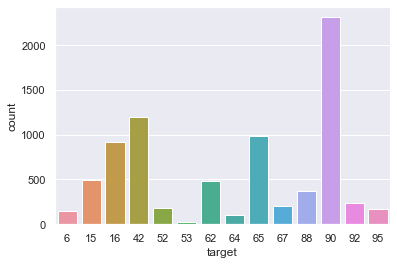

In [9]:
sns.countplot(x='target', data=training_set_metadata)


As we can see there are some classes that have a lot of elements and other classes that don't have a lot of data. The target 90 is the one that has more with 2313 elements. And 53 is the class with less elements, with a total of 30.

In [10]:
subset = training_set[training_set['object_id']==615]

passbands = subset['passband'].value_counts().index
classes_values = subset['passband'].value_counts().values
print(passbands)
print(classes_values)

Int64Index([0, 2, 1, 3, 4, 5], dtype='int64')
[63 58 58 58 58 57]


In [11]:
pbmap = {0:'u', 1:'g', 2:'r', 3:'i', 4:'z', 5:'y'}

# it also helps to have passbands associated with a color
pbcols = {0:'blueviolet', 1:'green', 2:'red',3:'orange', 4:'black', 5:'brown'}

pbnames = list(pbmap.values())
passbands = list(pbmap.keys())

#### Data preparation

In [12]:
training_set = training_set.set_index('object_id')
training_set_metadata = training_set_metadata.set_index('object_id')

In [13]:
ids = training_set.index.value_counts().index
train_data = pd.DataFrame(ids, columns=["object_id"])
targets = []
for pb in tqdm(passbands):
    fluxos = []
    subset = training_set[training_set['passband']==pb]
    for Id in ids:
        fluxos.append(subset['flux'][Id].to_list())
        if pb==0:
            targets.append(training_set_metadata['target'][Id])
    train_data[pbmap[pb]] = fluxos
train_data['target'] = targets

100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


In [14]:
train_data

,object_id,u,g,r,i,z,y,target
0,615,"[6.878784, 39.364853, -10.422381, -65.48513, -...","[-816.434326, -1061.457031, -815.188599, -820....","[-544.810303, -681.858887, -548.01355, -554.90...","[-471.385529, -524.95459, -475.516052, -477.00...","[-388.984985, -393.480225, -405.663818, -400.2...","[-355.88678, -421.199066, -415.286896, -422.81...",92
1,173059,"[-0.39187, 0.603427, 0.610694, -2.457228, -3.0...","[1.017174, 0.448582, 0.960755, -0.498255, -0.3...","[0.717085, -0.611219, 0.466379, 0.638848, 3.97...","[-1.103525, 2.375255, 0.336396, -1.217879, 2.2...","[-8.789351, -0.195498, -2.106559, 0.693419, 3....","[3.048188, -1.620498, 5.735075, 9.87141, -3.07...",90
2,167417,"[0.438574, -1.404275, 1.299085, 6.458389, -0.4...","[-3.282869, -0.75229, -1.19442, 1.85398, 7.378...","[-0.482153, 0.817074, -0.399877, 0.030646, 0.7...","[-1.769702, 0.002686, -0.306619, 0.170198, -4....","[20.813986, -2.2953, -1.139139, 1.512145, 0.19...","[-1.420491, 5.658321, -1.931078, 0.446385, -8....",90
3,167436,"[1.987344, 1.336312, 8.299458, 1.743594, 2.512...","[-3.669189, -0.610654, 0.61584, -6.19931, -4.2...","[-1.706974, -0.250367, 1.561528, 1.64785, -0.1...","[0.656871, -0.851225, -0.019419, -0.417339, 2....","[0.117346, -0.464868, -0.307112, -6.927296, -1...","[1.587195, 5.164978, -1.453949, 8.010317, 3.30...",90
4,167488,"[0.519336, -0.815361, 0.271095, -0.319268, -0....","[-1.212814, -0.56573, 0.185286, 3.508145, 3.32...","[1.736552, 1.874298, -0.175197, -0.30032, 2.21...","[2.316693, -1.765833, 0.599003, -0.953834, -3....","[5.903067, -0.627545, 1.038317, -2.137084, 6.1...","[-10.079162, 1.653859, -2.837296, -3.443591, 5...",90
...,...,...,...,...,...,...,...,...
7843,100413487,"[32.56554, 38.11459, -64.527847, -13.302895, -...","[38.859097, 32.882523, 24.454559, 24.434652, 2...","[14.106787, 25.025362, 19.577394, 28.082775, 3...","[-33.979992, 13.473109, 14.539824, 28.173706, ...","[-6.097461, -46.182285, 15.366582, 6.182258, 2...","[-24.870806, -4.035016, -33.343613, 22.689709,...",16
7844,68643457,"[-27.606262, 16.183664, 4.57474, 51.694954, 51...","[-4.96919, 4.666487, 1.415998, 1.582711]","[3.256188, -6.834228, 2.318946, -3.678753, -3....","[55.160851, -1.896123, -10.603094, 1289.137207...","[41.255001, 29.819336, 27.069757, -17.326483, ...","[-1.690391, 40.411282, 75.120895, 7.285213, 0....",90
7845,119353712,"[935.758484, 30.302742, -388.348907, 140.056, ...","[-4297.536621, 9265.561523, -4938.881348, 5108...","[-2618.585449, -1804.182007, 5116.262695, -478...","[-3561.2854, 6946.195312, -3913.899414, -971.2...","[-168.197342, -1891.615723, 2371.112793, -3939...","[-2851.245361, 6155.778809, -4959.649902, 1946...",92
7846,86237249,"[-199.904312, 8.472673, -91.719788, 169.568848...","[-24.659794, -0.144551, 13.509278, -1.596434, ...","[-5.585778, 15.475435, 25.84514, 2.627688, 143...","[9.24447, 193.779495, 81.081535, 47.396507, 10...","[-4.876873, -38.389866, -75.292038, 31.974199,...","[39.217594, 44.226509, -21.087267, -33.445827,...",42


In [15]:
ids = training_set.index.value_counts().index
train_data_time = pd.DataFrame(ids, columns=["object_id"])
targets = []
for pb in tqdm(passbands):
    times = []
    subset = training_set[training_set['passband']==pb]
    for Id in ids:
        times.append(subset['mjd'][Id].to_list())
        if pb==0:
            targets.append(training_set_metadata['target'][Id])
    train_data_time[pbmap[pb]] = times
train_data_time['target'] = targets

100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


In [16]:
train_data_time

,object_id,u,g,r,i,z,y,target
0,615,"[59819.1532, 59820.1047, 59821.1026, 59822.110...","[59750.4306, 59752.4147, 59767.3045, 59770.225...","[59750.4229, 59752.407, 59767.2968, 59770.2179...","[59750.4383, 59752.4224, 59767.3122, 59770.233...","[59750.445, 59752.4334, 59767.3233, 59770.2445...","[59752.4435, 59767.3343, 59770.2557, 59779.356...",92
1,173059,"[59819.1532, 59820.1047, 59821.1026, 59822.110...","[59750.4306, 59752.4147, 59767.3045, 59770.225...","[59750.4229, 59752.407, 59767.2968, 59770.2179...","[59750.4383, 59752.4224, 59767.3122, 59770.233...","[59750.445, 59752.4334, 59767.3233, 59770.2445...","[59752.4435, 59767.3343, 59770.2557, 59779.356...",90
2,167417,"[59819.1532, 59820.1047, 59821.1026, 59822.110...","[59750.4306, 59752.4147, 59767.3045, 59770.225...","[59750.4229, 59752.407, 59767.2968, 59770.2179...","[59750.4383, 59752.4224, 59767.3122, 59770.233...","[59750.445, 59752.4334, 59767.3233, 59770.2445...","[59752.4435, 59767.3343, 59770.2557, 59779.356...",90
3,167436,"[59819.1532, 59820.1047, 59821.1026, 59822.110...","[59750.4306, 59752.4147, 59767.3045, 59770.225...","[59750.4229, 59752.407, 59767.2968, 59770.2179...","[59750.4383, 59752.4224, 59767.3122, 59770.233...","[59750.445, 59752.4334, 59767.3233, 59770.2445...","[59752.4435, 59767.3343, 59770.2557, 59779.356...",90
4,167488,"[59819.1532, 59820.1047, 59821.1026, 59822.110...","[59750.4306, 59752.4147, 59767.3045, 59770.225...","[59750.4229, 59752.407, 59767.2968, 59770.2179...","[59750.4383, 59752.4224, 59767.3122, 59770.233...","[59750.445, 59752.4334, 59767.3233, 59770.2445...","[59752.4435, 59767.3343, 59770.2557, 59779.356...",90
...,...,...,...,...,...,...,...,...
7843,100413487,"[60027.2698, 60080.1505, 60200.0255, 60465.199...","[60026.327, 60057.1877, 60146.0906, 60468.1437...","[59787.0994, 59806.0586, 59813.0764, 59837.051...","[60052.2004, 60064.3288, 60103.2816, 60160.133...","[60041.3805, 60066.184, 60067.1725, 60484.263,...","[59802.135, 59830.0256, 60038.2726, 60039.2354...",16
7844,68643457,"[59702.3009, 60087.1998, 60436.2392, 60554.058...","[60057.2663, 60434.3175, 60442.2076, 60611.03]","[59701.3389, 59778.1432, 59792.9968, 59806.067...","[59776.0241, 60037.3462, 60056.2652, 60134.069...","[59749.2083, 59775.2862, 59776.2676, 60005.396...","[59715.2644, 60037.3325, 60432.4238, 60506.045...",90
7845,119353712,"[59702.3009, 60087.1998, 60436.2392, 60554.058...","[60057.2663, 60434.3175, 60442.2076, 60611.03]","[59701.3389, 59778.1432, 59792.9968, 59806.067...","[59776.0241, 60037.3462, 60056.2652, 60134.069...","[59749.2083, 59775.2862, 59776.2676, 60005.396...","[59715.2644, 60037.3325, 60432.4238, 60506.045...",92
7846,86237249,"[59697.3086, 60087.2182, 60140.1081, 60436.361...","[59779.1426, 59840.0501, 60177.1004, 60434.369...","[59701.3402, 59768.1506, 59793.0063, 59868.029...","[59721.285, 60056.3084, 60132.2807, 60137.1105...","[59722.2728, 59749.1185, 59775.2795, 59776.262...","[59767.0883, 59768.0896, 60153.068, 60432.4192...",42


In [17]:
N = 1
samples = train_data.groupby('target').apply(lambda x: x[:N])['object_id'].to_list()

In [18]:
t = training_set_metadata['target'][samples].to_list()

In [19]:
df = training_set.loc[samples]

In [20]:
tg = np.repeat(t[:12],352)
tg_f = np.concatenate([tg, np.repeat(t[12:],330)])

In [21]:
df['target'] = tg_f

In [22]:
df

,mjd,passband,flux,flux_err,detected,target
object_id,,,,,,
201890,59750.4229,2,798.867065,4.728840,1,6
201890,59750.4306,1,498.284912,4.030657,1,6
201890,59750.4383,3,894.352051,5.405053,1,6
201890,59750.4450,4,944.262634,12.342348,1,6
201890,59752.4070,2,921.111023,5.204936,1,6
...,...,...,...,...,...,...
95127,60624.1760,2,-1.042478,1.680804,0,95
95127,60624.1836,1,0.697185,2.300355,0,95
95127,60624.1913,3,2.973519,2.196870,0,95


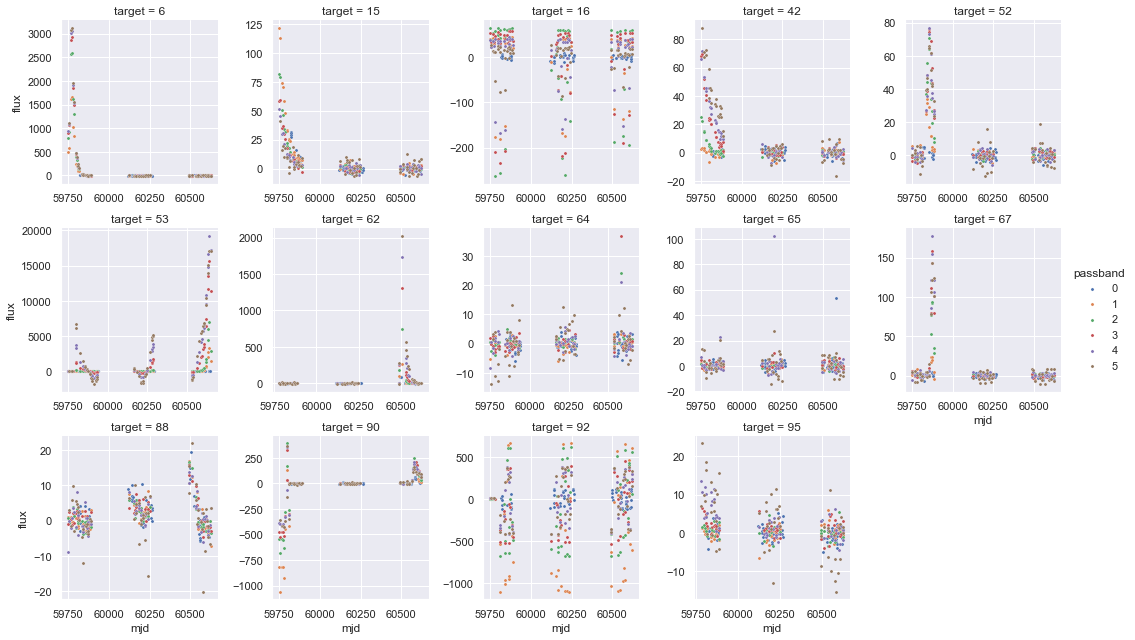

In [23]:
grid = sns.FacetGrid(df, col = "target", hue = 'passband', col_wrap=5, sharex=False, sharey=False)
grid.map(sns.scatterplot, "mjd", "flux", s=10)

grid.add_legend()

### Model for classifying

My first approach is to make a neural network using Fast Fourier Transform.
Fast Fourier Transform have very good properties and makes the complexity of CNN from O(n·n) to O(n·logn) which is a great improvement. 

#### Creating dataset for train and test

The first problem I encountered was the data. There are 6 types of fluxes for every object, with different lengths. As I didn't want to just calculate manually some features (risking not including important information) I opted to do feature extraction with a library called tsfresh. This library specializes in extracting features from temporal series, which was good for our type of data.

I then created the dataset with the columns I would need and I did the feature extraction. It took almost 50min to finish.

In [24]:
training_set = pd.read_csv('./data/training_set.csv')

In [25]:
dataset = training_set[['object_id','passband','mjd','flux']]

In [28]:
#extracted_features = extract_features(dataset, column_id="object_id", column_sort="mjd", column_kind="passband", column_value="flux", n_jobs=0)

In [29]:
#extracted_features.to_csv (r'.\extracted_features.csv', index = True, header=True)

In [37]:
extracted_features

,Unnamed: 0,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,...,5__permutation_entropy__dimension_6__tau_1,5__permutation_entropy__dimension_7__tau_1,5__query_similarity_count__query_None__threshold_0.0,"5__matrix_profile__feature_""min""__threshold_0.98","5__matrix_profile__feature_""max""__threshold_0.98","5__matrix_profile__feature_""mean""__threshold_0.98","5__matrix_profile__feature_""median""__threshold_0.98","5__matrix_profile__feature_""25""__threshold_0.98","5__matrix_profile__feature_""75""__threshold_0.98",5__mean_n_absolute_max__number_of_maxima_7
0,615,1.0,0.0,0.0,0.0,-205.036926,4.375639e+05,51.531037,1.847308,-0.261666,...,3.871265,3.904643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,416.097695
1,713,1.0,0.0,0.0,0.0,-190.427851,4.009578e+03,2.928718,-0.230969,0.048351,...,3.877461,3.912023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.771713
2,730,1.0,0.0,0.0,0.0,-3.461790,2.376454e+02,2.187693,0.054023,-0.024812,...,3.828641,3.806662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.853438
3,745,1.0,0.0,0.0,0.0,129.421659,1.591278e+03,2.886643,-0.014768,-0.011122,...,3.790654,3.891820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.210881
4,1124,1.0,0.0,0.0,0.0,41.639721,3.728616e+02,2.625952,0.043033,-0.009378,...,3.924584,3.931826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.365929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,1.0,0.0,0.0,0.0,21.873135,4.123384e+03,15.449995,-0.057736,0.622525,...,3.401197,3.367296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.691010
7844,130755807,1.0,0.0,0.0,0.0,295.622920,7.718016e+04,60.384472,-1.405664,-1.234285,...,3.367296,3.332205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.227636
7845,130762946,1.0,0.0,0.0,0.0,-3.677885,2.606556e+04,51.765809,0.697575,-2.284384,...,3.258097,3.218876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.834487
7846,130772921,1.0,0.0,0.0,0.0,47.238909,2.862642e+03,14.379540,-1.014011,0.648643,...,3.515740,3.526361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.207506


In [102]:
extracted_features = extracted_features.set_index(['Unnamed: 0'])
extracted_features.index.name = 'object_id'

In [103]:
training_set_metadata = training_set_metadata.set_index(['object_id'])
y = pd.Series(training_set_metadata['target'])

I got a huge dataset with 4734 new features as columns. Just taking a look you can see that it needs some cleaning. I took off all the columns that had NaN and all the columns that had the same value in each row.

In [69]:
extracted_features = extracted_features.dropna(axis=1)

By taking off all the NaN I got 1739 features. Now I take off all the columns with the same value

In [70]:
def unique_cols(df):
    a = df.to_numpy() # df.values (pandas<0.24)
    return (a[0] == a).all(0)

In [71]:
extracted_features = extracted_features.drop(extracted_features.columns[unique_cols(extracted_features)], axis=1)

The result is the next dataset with 1502 features or columns.

In [72]:
extracted_features

,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__median,0__mean,0__length,0__standard_deviation,0__variation_coefficient,0__variance,...,5__fourier_entropy__bins_2,5__fourier_entropy__bins_3,5__fourier_entropy__bins_5,5__fourier_entropy__bins_10,5__fourier_entropy__bins_100,5__permutation_entropy__dimension_3__tau_1,5__permutation_entropy__dimension_4__tau_1,5__permutation_entropy__dimension_5__tau_1,5__permutation_entropy__dimension_6__tau_1,5__permutation_entropy__dimension_7__tau_1
object_id,,,,,,,,,,,,,,,,,,,,,
615,-205.036926,4.375639e+05,51.531037,1.847308,-10.015225,-3.254554,63.0,83.275842,-25.587479,6.934866e+03,...,0.459693,0.832571,1.285000,1.827594,3.158040,1.680344,2.815022,3.522170,3.871265,3.904643
713,-190.427851,4.009578e+03,2.928718,-0.230969,-3.096805,-2.720398,70.0,7.062516,-2.596133,4.987913e+01,...,0.250955,0.603035,1.047042,1.616301,3.014630,1.751832,2.939805,3.684649,3.877461,3.912023
730,-3.461790,2.376454e+02,2.187693,0.054023,0.024093,-0.048080,72.0,1.816127,-37.772702,3.298318e+00,...,0.540204,0.687092,1.118891,1.497027,2.704781,1.768728,2.930840,3.673174,3.828641,3.806662
745,129.421659,1.591278e+03,2.886643,-0.014768,1.056714,1.797523,72.0,4.343961,2.416637,1.886999e+01,...,0.340500,0.408698,0.801260,1.348983,2.731527,1.680996,2.673049,3.422026,3.790654,3.891820
1124,41.639721,3.728616e+02,2.625952,0.043033,0.581027,0.660948,63.0,2.341279,3.542304,5.481586e+00,...,0.459693,0.717505,1.143043,1.711290,2.966827,1.788928,2.981309,3.725011,3.924584,3.931826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130739978,21.873135,4.123384e+03,15.449995,-0.057736,0.566667,1.286655,17.0,15.520841,12.062940,2.408965e+02,...,0.450561,0.683739,0.960892,1.347975,2.553237,1.776446,2.750504,3.344549,3.401197,3.367296
130755807,295.622920,7.718016e+04,60.384472,-1.405664,3.523321,24.635243,12.0,76.320279,3.098012,5.824785e+03,...,0.636514,0.786701,1.300592,1.406678,2.582306,1.726788,2.746321,3.262568,3.367296,3.332205
130762946,-3.677885,2.606556e+04,51.765809,0.697575,7.376702,-0.282914,13.0,44.776815,-158.269928,2.004963e+03,...,0.685314,1.071730,1.489849,2.014036,2.772589,1.766037,2.799725,3.244493,3.258097,3.218876


I do a last feature selection

In [73]:
selected_features = feature_selection.select_features(extracted_features, y, ml_task='classification', multiclass=True, n_jobs=0)

In [74]:
selected_features

,"2__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","2__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","3__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","2__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","1__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2","3__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","2__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2","4__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","3__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2",1__mean_abs_change,...,"1__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.4",4__autocorrelation__lag_6,"3__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",5__symmetry_looking__r_0.15000000000000002,4__large_standard_deviation__r_0.4,2__symmetry_looking__r_0.30000000000000004,5__large_standard_deviation__r_0.4,5__symmetry_looking__r_0.25,4__symmetry_looking__r_0.30000000000000004,4__symmetry_looking__r_0.25
object_id,,,,,,,,,,,,,,,,,,,,,
615,300.935462,118501.387659,281.969497,31194.984390,539.933301,108354.752421,425.894203,208.143351,42478.340233,657.025941,...,10761.229809,0.058400,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
713,1.561348,3.407380,2.876058,1.424327,2.138922,13.690853,2.120542,1.714702,5.520683,2.241918,...,1.129268,0.629594,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
730,0.858019,1.172991,1.744106,0.470820,1.543100,4.390104,1.996276,1.875823,1.350531,1.845462,...,0.090832,0.066051,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
745,1.394411,4.698467,1.697170,3.031026,6.224206,5.070577,12.356502,2.672516,2.364372,8.485260,...,0.133846,0.089490,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
1124,0.987417,1.670091,1.275860,0.770273,3.316546,3.103657,6.491404,1.562860,1.641119,2.772622,...,0.745799,0.094736,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130739978,3.262261,15.835636,2.922762,5.524589,38.026759,13.032673,11.791437,10.948467,5.185756,27.505493,...,0.000000,0.020870,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
130755807,3.741628,10.221534,6.141984,2.677271,21.583167,32.756064,5.288134,7.859016,32.756064,13.791179,...,0.000000,-0.161550,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
130762946,18.772186,526.373570,18.937071,187.111115,9.196110,358.612677,28.954324,9.477104,40.750457,20.396381,...,0.000000,0.008401,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0


So, we got 1391 features to work with.

Then, I divided the dataset in train and test.

In [90]:
random.seed = 0
idx = selected_features.index.to_list()
random.shuffle(idx)

train_size = 0.8

idx_train = idx[:int(len(idx)*train_size)]
idx_test = idx[int(len(idx)*train_size):]

classes_to_labels = {90:0, 42:1, 65:2, 16:3, 15:4, 62:5, 88:6, 92:7, 67:8, 52:9, 95:10, 6:11, 64:12, 53:13}
labels_to_classes = {0:90, 1:42, 2:65, 3:16, 4:15, 5:62, 6:88, 7:92, 8:67, 9:52, 10:95, 11:6, 12:64, 13:53}

data_train = selected_features.loc[idx_train]
data_test = selected_features.loc[idx_test]
x_train = np.array(data_train)
y_train = np.array([classes_to_labels[x] for x in training_set_metadata['target'].loc[idx_train]])
x_test = np.array(data_test)
y_test = np.array([classes_to_labels[x] for x in training_set_metadata['target'].loc[idx_test]])

In [76]:
print(x_train.shape, x_test.shape)

(6278, 1391) (1570, 1391)


In [133]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(x_train), torch.tensor(y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(x_test), torch.tensor(y_test)), batch_size=batch_size, shuffle=False)

In [78]:
x_train.dtype

torch.float64

The dataset is prepared for train and test. Now the neural network model must be implemented.

#### Model

We want to be able to train our model on a hardware accelerator like the GPU, if it is available. Let’s check to see if torch.cuda is available, else we continue to use the CPU.

In [193]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


We define our class

In [194]:
input_size = 1391 #number of features per object
output_size = 14 #classes to classify 
modes = 15
width = 2

IMP. I modified the Fourier Neural Operator from 
`
@misc{li2021fourier,
title={Fourier Neural Operator for Parametric Partial Differential Equations},
author={Zongyi Li and Nikola Kovachki and Kamyar Azizzadenesheli and Burigede Liu and Kaushik Bhattacharya and Andrew Stuart and Anima Anandkumar},
year={2021},
eprint={2010.08895},
archivePrefix={arXiv},
primaryClass={cs.LG}
}`

In [203]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes  #Number of Fourier modes to multiply, at most floor(N/2) + 1
        
        self.scale = (1 / (in_channels*out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

In [204]:
class FourierNeuralNetwork(nn.Module):
    def __init__(self, modes, width, input_size):
        super(FourierNeuralNetwork, self).__init__()
        self.width = width
        self.modes = modes
        
        self.fc0 = nn.Linear(1, self.width)

        self.padding = 2 # pad the domain if input is non-periodic

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)

        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(input_size*self.width, 280)
        self.fc2 = nn.Linear(280, 14)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x[:,:,None]
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        x = torch.nn.functional.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = torch.nn.functional.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = torch.nn.functional.gelu(x)

        x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = self.fc1(x)
        x = torch.nn.functional.gelu(x)

        x = self.fc2(x)
        x = self.softmax(x)
        return x
    

In [205]:
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

In [206]:
# model
model = FourierNeuralNetwork(modes, width, input_size).cuda()
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

FourierNeuralNetwork(
  (fc0): Linear(in_features=1, out_features=2, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (w0): Conv1d(2, 2, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(2, 2, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=2782, out_features=280, bias=True)
  (fc2): Linear(in_features=280, out_features=14, bias=True)
  (softmax): Softmax(dim=1)
)
783310


In [207]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [200]:
correct = 0
total = 0
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.cuda(), y.type(torch.LongTensor)
        y = y.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        out = model(x.float())
        
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    if (epoch + 1) % 10 == 0:
        print(f'epoch {epoch+1}/{epochs}, loss={running_loss:.4f}')
    scheduler.step()


print('Finished Training')

  2%|▏         | 10/500 [00:34<28:04,  3.44s/it]

epoch 10/500, loss=483.9612


  4%|▍         | 20/500 [01:08<27:03,  3.38s/it]

epoch 20/500, loss=483.6905


  6%|▌         | 30/500 [01:42<27:15,  3.48s/it]

epoch 30/500, loss=483.9624


  8%|▊         | 40/500 [02:17<26:22,  3.44s/it]

epoch 40/500, loss=484.0965


 10%|█         | 50/500 [02:51<25:29,  3.40s/it]

epoch 50/500, loss=483.9616


 12%|█▏        | 60/500 [03:24<24:45,  3.38s/it]

epoch 60/500, loss=484.0968


 14%|█▍        | 70/500 [03:58<24:18,  3.39s/it]

epoch 70/500, loss=483.9545


 16%|█▌        | 80/500 [04:32<24:12,  3.46s/it]

epoch 80/500, loss=483.9719


 18%|█▊        | 90/500 [05:06<22:53,  3.35s/it]

epoch 90/500, loss=484.0343


 20%|██        | 100/500 [05:40<22:36,  3.39s/it]

epoch 100/500, loss=484.0969


 22%|██▏       | 110/500 [06:17<24:53,  3.83s/it]

epoch 110/500, loss=483.9614


 24%|██▍       | 120/500 [06:52<21:55,  3.46s/it]

epoch 120/500, loss=483.8988


 26%|██▌       | 130/500 [07:25<20:38,  3.35s/it]

epoch 130/500, loss=483.9614


 28%|██▊       | 140/500 [07:59<19:51,  3.31s/it]

epoch 140/500, loss=484.0967


 30%|███       | 150/500 [08:33<19:33,  3.35s/it]

epoch 150/500, loss=483.9301


 32%|███▏      | 160/500 [09:07<20:01,  3.53s/it]

epoch 160/500, loss=483.8989


 34%|███▍      | 170/500 [09:41<18:01,  3.28s/it]

epoch 170/500, loss=483.9300


 36%|███▌      | 180/500 [10:15<18:50,  3.53s/it]

epoch 180/500, loss=483.8364


 38%|███▊      | 190/500 [10:49<16:29,  3.19s/it]

epoch 190/500, loss=483.7635


 40%|████      | 200/500 [11:27<18:50,  3.77s/it]

epoch 200/500, loss=484.0653


 42%|████▏     | 210/500 [12:01<16:26,  3.40s/it]

epoch 210/500, loss=484.0969


 44%|████▍     | 220/500 [12:35<15:42,  3.37s/it]

epoch 220/500, loss=484.0967


 46%|████▌     | 230/500 [13:09<15:11,  3.38s/it]

epoch 230/500, loss=483.9612


 48%|████▊     | 240/500 [13:43<15:32,  3.59s/it]

epoch 240/500, loss=483.9612


 50%|█████     | 250/500 [14:19<14:46,  3.55s/it]

epoch 250/500, loss=484.2323


 52%|█████▏    | 260/500 [14:53<13:43,  3.43s/it]

epoch 260/500, loss=483.8259


 54%|█████▍    | 270/500 [15:30<13:43,  3.58s/it]

epoch 270/500, loss=484.2321


 56%|█████▌    | 280/500 [16:05<12:43,  3.47s/it]

epoch 280/500, loss=483.8258


 58%|█████▊    | 290/500 [16:42<12:35,  3.60s/it]

epoch 290/500, loss=483.9614


 60%|██████    | 300/500 [17:17<12:01,  3.61s/it]

epoch 300/500, loss=483.9613


 62%|██████▏   | 310/500 [17:52<11:21,  3.59s/it]

epoch 310/500, loss=484.0967


 64%|██████▍   | 320/500 [18:27<10:10,  3.39s/it]

epoch 320/500, loss=484.0967


 66%|██████▌   | 330/500 [19:01<09:40,  3.42s/it]

epoch 330/500, loss=483.9613


 68%|██████▊   | 340/500 [19:36<09:18,  3.49s/it]

epoch 340/500, loss=484.0967


 70%|███████   | 350/500 [20:11<08:46,  3.51s/it]

epoch 350/500, loss=484.2321


 72%|███████▏  | 360/500 [20:45<07:57,  3.41s/it]

epoch 360/500, loss=483.9613


 74%|███████▍  | 370/500 [21:19<07:23,  3.42s/it]

epoch 370/500, loss=483.6905


 76%|███████▌  | 380/500 [21:53<06:42,  3.35s/it]

epoch 380/500, loss=484.2322


 78%|███████▊  | 390/500 [22:26<06:04,  3.31s/it]

epoch 390/500, loss=484.0967


 80%|████████  | 400/500 [22:59<05:30,  3.31s/it]

epoch 400/500, loss=483.9613


 82%|████████▏ | 410/500 [23:33<04:56,  3.29s/it]

epoch 410/500, loss=483.8259


 84%|████████▍ | 420/500 [24:07<04:36,  3.45s/it]

epoch 420/500, loss=484.2321


 86%|████████▌ | 430/500 [24:41<03:58,  3.41s/it]

epoch 430/500, loss=484.0967


 88%|████████▊ | 440/500 [25:16<03:23,  3.40s/it]

epoch 440/500, loss=484.0967


 90%|█████████ | 450/500 [25:50<02:54,  3.49s/it]

epoch 450/500, loss=484.0967


 92%|█████████▏| 460/500 [26:24<02:13,  3.34s/it]

epoch 460/500, loss=483.9613


 94%|█████████▍| 470/500 [26:58<01:41,  3.38s/it]

epoch 470/500, loss=484.0967


 96%|█████████▌| 480/500 [27:30<01:05,  3.26s/it]

epoch 480/500, loss=483.8259


 98%|█████████▊| 490/500 [28:03<00:33,  3.33s/it]

epoch 490/500, loss=483.9613


100%|██████████| 500/500 [28:38<00:00,  3.44s/it]

epoch 500/500, loss=483.9613
Finished Training


In [202]:
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()

        out = model(x.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(out.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
print(f'Accuracy of the network on the 1570 test objects: {100 * correct // total} %')

Accuracy of the network on the 1570 test objects: 28 %


Training with only extracted_features -> 38% (32 size batches)

Training with only extracted_features -> 34% (64 size batches)

Training with only extracted_features -> 28% (64 size batches) width 2 without padding

Training with only extracted_features -> 35% (64 size batches) width 2 with padding

Training with only extracted_features -> 36% (32 size batches) width 2 with padding 10 modes

Training with only extracted_features -> 36% (32 size batches) width 2 with padding 15 modes

The result is not satisfactory. I decided to use other methods:

In [89]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [148]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LinearDiscriminantAnalysis()
    ]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(x_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(x_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 49.2994%
Log Loss: 11.61741627794788
DecisionTreeClassifier
****Results****
Accuracy: 53.4395%
Log Loss: 16.0814302832355
RandomForestClassifier
****Results****
Accuracy: 68.6624%
Log Loss: 1.1630728597002553
LinearDiscriminantAnalysis
****Results****
Accuracy: 63.5032%
Log Loss: 3.153569491553793


I also tried a a multi-layer perceptron, but again I did not get good results.

In [97]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(500, 14), 
                    max_iter=500, verbose = True)


mlp.fit(x_train, y_train)
print("Training set score: %f" % mlp.score(x_train, y_train))
print("Test set score: %f" % mlp.score(x_test, y_test))

Iteration 1, loss = 31.65554561
Iteration 2, loss = 21.92490867
Iteration 3, loss = 13.28550670
Iteration 4, loss = 8.43755959
Iteration 5, loss = 7.42771547
Iteration 6, loss = 6.83471697
Iteration 7, loss = 6.51305385
Iteration 8, loss = 6.16473547
Iteration 9, loss = 5.90842184
Iteration 10, loss = 5.74013473
Iteration 11, loss = 5.54210052
Iteration 12, loss = 5.39144260
Iteration 13, loss = 5.32644867
Iteration 14, loss = 5.24376511
Iteration 15, loss = 5.34905293
Iteration 16, loss = 5.08883094
Iteration 17, loss = 4.95558121
Iteration 18, loss = 4.84856394
Iteration 19, loss = 4.79625438
Iteration 20, loss = 4.69075657
Iteration 21, loss = 4.56150118
Iteration 22, loss = 4.45831363
Iteration 23, loss = 4.39778947
Iteration 24, loss = 4.31811652
Iteration 25, loss = 4.29554385
Iteration 26, loss = 4.25451037
Iteration 27, loss = 4.06796296
Iteration 28, loss = 3.95260855
Iteration 29, loss = 3.90570043
Iteration 30, loss = 3.85941896
Iteration 31, loss = 3.79285612
Iteration 32, 

The results with Random Forest were the best. Next thing to try was to use the extra data of training_set_metadata.

In [98]:
extracted_features['ra'] = training_set_metadata['ra']
extracted_features['decl'] = training_set_metadata['decl']
extracted_features['gal_l'] = training_set_metadata['gal_l']
extracted_features['gal_b'] = training_set_metadata['gal_b']
extracted_features['ddf'] = training_set_metadata['ddf']
extracted_features['hostgal_specz'] = training_set_metadata['hostgal_specz']
extracted_features['hostgal_photoz'] = training_set_metadata['hostgal_photoz']
extracted_features['hostgal_photoz_err'] = training_set_metadata['hostgal_photoz_err']
extracted_features['mwebv'] = training_set_metadata['mwebv']

In [104]:
selected_features_2 = feature_selection.select_features(extracted_features, y, ml_task='classification', multiclass=True, n_jobs=0)

In [105]:
selected_features_2

,"2__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","2__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","3__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","2__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","1__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2","3__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","2__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2","4__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","3__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2",1__mean_abs_change,...,"1__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.4",4__autocorrelation__lag_6,"3__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",4__large_standard_deviation__r_0.4,5__symmetry_looking__r_0.15000000000000002,5__symmetry_looking__r_0.25,5__large_standard_deviation__r_0.4,4__symmetry_looking__r_0.25,2__symmetry_looking__r_0.30000000000000004,4__symmetry_looking__r_0.30000000000000004
object_id,,,,,,,,,,,,,,,,,,,,,
615,300.935462,118501.387659,281.969497,31194.984390,539.933301,108354.752421,425.894203,208.143351,42478.340233,657.025941,...,10761.229809,0.058400,2.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
713,1.561348,3.407380,2.876058,1.424327,2.138922,13.690853,2.120542,1.714702,5.520683,2.241918,...,1.129268,0.629594,2.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
730,0.858019,1.172991,1.744106,0.470820,1.543100,4.390104,1.996276,1.875823,1.350531,1.845462,...,0.090832,0.066051,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
745,1.394411,4.698467,1.697170,3.031026,6.224206,5.070577,12.356502,2.672516,2.364372,8.485260,...,0.133846,0.089490,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1124,0.987417,1.670091,1.275860,0.770273,3.316546,3.103657,6.491404,1.562860,1.641119,2.772622,...,0.745799,0.094736,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130739978,3.262261,15.835636,2.922762,5.524589,38.026759,13.032673,11.791437,10.948467,5.185756,27.505493,...,0.000000,0.020870,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
130755807,3.741628,10.221534,6.141984,2.677271,21.583167,32.756064,5.288134,7.859016,32.756064,13.791179,...,0.000000,-0.161550,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
130762946,18.772186,526.373570,18.937071,187.111115,9.196110,358.612677,28.954324,9.477104,40.750457,20.396381,...,0.000000,0.008401,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [106]:
random.seed = 0
idx = selected_features_2.index.to_list()
random.shuffle(idx)

train_size = 0.8

idx_train = idx[:int(len(idx)*train_size)]
idx_test = idx[int(len(idx)*train_size):]

classes_to_labels = {90:0, 42:1, 65:2, 16:3, 15:4, 62:5, 88:6, 92:7, 67:8, 52:9, 95:10, 6:11, 64:12, 53:13}
labels_to_classes = {0:90, 1:42, 2:65, 3:16, 4:15, 5:62, 6:88, 7:92, 8:67, 9:52, 10:95, 11:6, 12:64, 13:53}

data_train = selected_features_2.loc[idx_train]
data_test = selected_features_2.loc[idx_test]
x_train_2 = np.array(data_train)
y_train_2 = np.array([classes_to_labels[x] for x in training_set_metadata['target'].loc[idx_train]])
x_test_2 = np.array(data_test)
y_test_2 = np.array([classes_to_labels[x] for x in training_set_metadata['target'].loc[idx_test]])

In [150]:
batch_size = 32

train_loader_2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(x_train_2), torch.tensor(y_train_2)), batch_size=batch_size, shuffle=True)
test_loader_2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(x_test_2), torch.tensor(y_test_2)), batch_size=batch_size, shuffle=False)

Using Fourier Neural Operator

In [151]:
input_size = 1398 #number of features per object
# model
model = FourierNeuralNetwork(modes, width, input_size).cuda()
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

FourierNeuralNetwork(
  (fc0): Linear(in_features=1, out_features=2, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (w0): Conv1d(2, 2, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(2, 2, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=2796, out_features=280, bias=True)
  (fc3): Linear(in_features=280, out_features=14, bias=True)
  (softmax): Softmax(dim=1)
)
787230


In [152]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [153]:
correct = 0
total = 0
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for x, y in train_loader_2:
        x, y = x.cuda(), y.type(torch.LongTensor)
        y = y.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        out = model(x.float())
        
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    if (epoch + 1) % 10 == 0:
        print(f'epoch {epoch+1}/{epochs}, loss={running_loss:.4f}')
    scheduler.step()


print('Finished Training')

  2%|▏         | 10/500 [00:28<22:55,  2.81s/it]

epoch 10/500, loss=484.8886


  4%|▍         | 20/500 [00:49<17:15,  2.16s/it]

epoch 20/500, loss=485.0240


  6%|▌         | 30/500 [01:12<17:25,  2.22s/it]

epoch 30/500, loss=484.8881


  8%|▊         | 40/500 [01:33<16:11,  2.11s/it]

epoch 40/500, loss=484.8889


 10%|█         | 50/500 [01:53<15:31,  2.07s/it]

epoch 50/500, loss=485.0233


 12%|█▏        | 60/500 [02:15<15:54,  2.17s/it]

epoch 60/500, loss=485.2942


 14%|█▍        | 70/500 [02:40<17:20,  2.42s/it]

epoch 70/500, loss=484.8881


 16%|█▌        | 80/500 [03:06<20:38,  2.95s/it]

epoch 80/500, loss=485.1587


 18%|█▊        | 90/500 [03:30<16:35,  2.43s/it]

epoch 90/500, loss=484.8879


 20%|██        | 100/500 [03:54<15:34,  2.34s/it]

epoch 100/500, loss=485.1587


 22%|██▏       | 110/500 [04:17<15:01,  2.31s/it]

epoch 110/500, loss=485.0233


 24%|██▍       | 120/500 [04:40<14:38,  2.31s/it]

epoch 120/500, loss=484.6170


 26%|██▌       | 130/500 [05:03<13:41,  2.22s/it]

epoch 130/500, loss=485.1587


 28%|██▊       | 140/500 [05:25<12:51,  2.14s/it]

epoch 140/500, loss=485.1587


 30%|███       | 150/500 [05:48<12:42,  2.18s/it]

epoch 150/500, loss=485.0234


 32%|███▏      | 160/500 [06:08<11:39,  2.06s/it]

epoch 160/500, loss=484.7526


 34%|███▍      | 170/500 [06:29<11:16,  2.05s/it]

epoch 170/500, loss=485.2943


 36%|███▌      | 180/500 [06:51<12:24,  2.33s/it]

epoch 180/500, loss=484.8882


 38%|███▊      | 190/500 [07:13<11:40,  2.26s/it]

epoch 190/500, loss=485.2947


 40%|████      | 200/500 [07:36<11:10,  2.23s/it]

epoch 200/500, loss=485.1590


 42%|████▏     | 210/500 [07:58<10:55,  2.26s/it]

epoch 210/500, loss=485.1589


 44%|████▍     | 220/500 [08:20<10:12,  2.19s/it]

epoch 220/500, loss=485.1591


 46%|████▌     | 230/500 [08:42<10:16,  2.28s/it]

epoch 230/500, loss=485.1591


 48%|████▊     | 240/500 [09:04<09:10,  2.12s/it]

epoch 240/500, loss=485.0238


 50%|█████     | 250/500 [09:27<09:46,  2.35s/it]

epoch 250/500, loss=485.0236


 52%|█████▏    | 260/500 [09:51<09:20,  2.34s/it]

epoch 260/500, loss=485.0200


 54%|█████▍    | 270/500 [10:13<08:38,  2.25s/it]

epoch 270/500, loss=485.0200


 56%|█████▌    | 280/500 [10:35<07:58,  2.17s/it]

epoch 280/500, loss=485.2945


 58%|█████▊    | 290/500 [10:58<07:49,  2.24s/it]

epoch 290/500, loss=485.1277


 60%|██████    | 300/500 [11:20<07:12,  2.16s/it]

epoch 300/500, loss=485.0236


 62%|██████▏   | 310/500 [11:43<07:15,  2.29s/it]

epoch 310/500, loss=484.8882


 64%|██████▍   | 320/500 [12:06<07:00,  2.34s/it]

epoch 320/500, loss=485.2944


 66%|██████▌   | 330/500 [12:28<06:19,  2.23s/it]

epoch 330/500, loss=484.8881


 68%|██████▊   | 340/500 [12:50<05:51,  2.20s/it]

epoch 340/500, loss=485.1590


 70%|███████   | 350/500 [13:11<05:11,  2.08s/it]

epoch 350/500, loss=485.1590


 72%|███████▏  | 360/500 [13:32<04:54,  2.10s/it]

epoch 360/500, loss=485.1590


 74%|███████▍  | 370/500 [13:55<04:50,  2.23s/it]

epoch 370/500, loss=485.0236


 76%|███████▌  | 380/500 [14:18<04:38,  2.32s/it]

epoch 380/500, loss=485.0236


 78%|███████▊  | 390/500 [14:40<04:05,  2.24s/it]

epoch 390/500, loss=484.8882


 80%|████████  | 400/500 [15:02<03:43,  2.24s/it]

epoch 400/500, loss=485.0236


 82%|████████▏ | 410/500 [15:24<03:16,  2.19s/it]

epoch 410/500, loss=485.1590


 84%|████████▍ | 420/500 [15:46<02:56,  2.21s/it]

epoch 420/500, loss=484.8882


 86%|████████▌ | 430/500 [16:08<02:40,  2.29s/it]

epoch 430/500, loss=485.0236


 88%|████████▊ | 440/500 [16:30<02:04,  2.08s/it]

epoch 440/500, loss=485.0236


 90%|█████████ | 450/500 [17:01<02:26,  2.94s/it]

epoch 450/500, loss=484.8882


 92%|█████████▏| 460/500 [17:23<01:27,  2.18s/it]

epoch 460/500, loss=485.1590


 94%|█████████▍| 470/500 [17:45<01:03,  2.12s/it]

epoch 470/500, loss=485.2944


 96%|█████████▌| 480/500 [18:06<00:44,  2.21s/it]

epoch 480/500, loss=485.0236


 98%|█████████▊| 490/500 [18:29<00:22,  2.26s/it]

epoch 490/500, loss=485.1590


100%|██████████| 500/500 [18:51<00:00,  2.26s/it]

epoch 500/500, loss=485.0236
Finished Training


In [154]:
model.eval()
with torch.no_grad():
    for x, y in test_loader_2:
        x, y = x.cuda(), y.cuda()

        out = model(x.float())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(out.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
print(f'Accuracy of the network on the 1570 test objects: {100 * correct // total} %')

Accuracy of the network on the 1570 test objects: 30 %


accuracy 30% no padding batch 64 width 1 modes 10

accuracy 30% padding batch 32 width 2 modes 15

We even got a smaller accuracy with this dataset and this neural network.

In [149]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LinearDiscriminantAnalysis()
    ]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(x_train_2, y_train_2)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(x_test_2)
    acc = accuracy_score(y_test_2, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(x_test_2)
    ll = log_loss(y_test_2, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 48.1529%
Log Loss: 11.72054763023605
DecisionTreeClassifier
****Results****
Accuracy: 65.9236%
Log Loss: 11.769583039030087
RandomForestClassifier
****Results****
Accuracy: 71.9745%
Log Loss: 0.9585655862673682
LinearDiscriminantAnalysis
****Results****
Accuracy: 65.6688%
Log Loss: 3.165586003647774


Not bad, the results of the Random Forest are a bit better.

Next we use again the multi-layer perceptron with this dataset:

In [116]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(500, 14), 
                    max_iter=500, verbose = True)


mlp.fit(x_train_2, y_train_2)
print("Training set score: %f" % mlp.score(x_train_2, y_train_2))
print("Test set score: %f" % mlp.score(x_test_2, y_test_2))

Iteration 1, loss = 24.14552985
Iteration 2, loss = 15.90160163
Iteration 3, loss = 9.79468651
Iteration 4, loss = 7.78743303
Iteration 5, loss = 7.27043549
Iteration 6, loss = 6.57368607
Iteration 7, loss = 5.97963057
Iteration 8, loss = 5.51541338
Iteration 9, loss = 5.14584444
Iteration 10, loss = 4.81872554
Iteration 11, loss = 4.56941515
Iteration 12, loss = 4.41320363
Iteration 13, loss = 4.20690859
Iteration 14, loss = 4.05093723
Iteration 15, loss = 3.91068232
Iteration 16, loss = 3.79282524
Iteration 17, loss = 3.70157054
Iteration 18, loss = 3.62723337
Iteration 19, loss = 3.54998336
Iteration 20, loss = 3.49061203
Iteration 21, loss = 3.46365970
Iteration 22, loss = 3.41535101
Iteration 23, loss = 3.35331038
Iteration 24, loss = 3.30989567
Iteration 25, loss = 3.27196737
Iteration 26, loss = 3.24055743
Iteration 27, loss = 3.21084492
Iteration 28, loss = 3.17130292
Iteration 29, loss = 3.12758524
Iteration 30, loss = 3.09248067
Iteration 31, loss = 3.07327443
Iteration 32, l

Accuracy keeps being too small, so we discard this classifier.

Lastly, I'll do fine tuning. Basically we do a search grid with a 100 different combinations of the parameters. This way we can select the parameters that provide us with the best accuracy.

In [156]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [158]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(x_train_2, y_train_2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

It took approx. 3 hours to finish. And the nest combination of parameters is the following:

In [159]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

We compare the performance of the basic model and the modified model with the best combination of parameters.

In [167]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = np.sum(predictions != test_labels)
    mape = 100 * np.mean(errors / len(test_labels))
    accuracy = 100 - mape
    print('Model Performance')
    print('Bad classified: {} objects.'.format(errors))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x_train_2, y_train_2)
base_accuracy = evaluate(base_model, x_test_2, y_test_2)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test_2, y_test_2)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Bad classified: 495 objects.
Accuracy = 68.47%.
Model Performance
Bad classified: 418 objects.
Accuracy = 73.38%.
Improvement of 7.16%.


To observe the results for each class I do a confusion matrix. Each row represents a class and each column the percentage that was classified as each class. So, the number in the diagonals are the percentage of objects classified correctly. 

<AxesSubplot:>

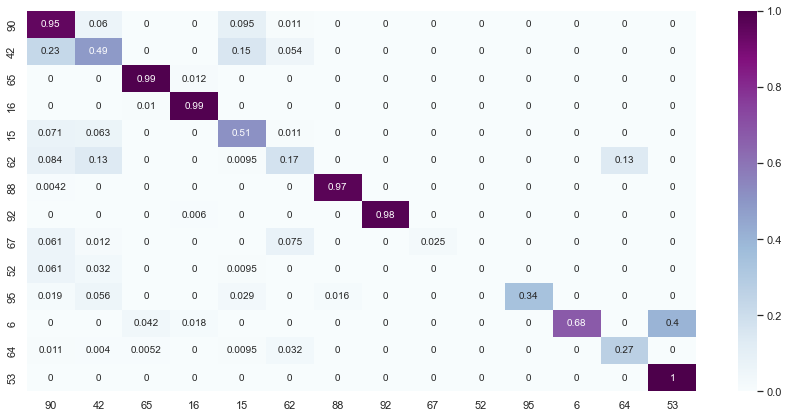

In [201]:
from sklearn import metrics
import matplotlib.pyplot as plt
pred = best_random.predict(x_test_2)
cm = metrics.confusion_matrix(y_test_2, pred)
cm = cm / cm.sum(axis=1)
df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (15,7))
sns.heatmap(df_cm, annot=True, cmap="BuPu")

We can see that some classes are very well classfied, like target 90, 65 or 16. But there are some classes that were very poorly classified, like target 67 or 52.

The next plot was used in the presentation to sump up the accuracy results for each dataset and each method.

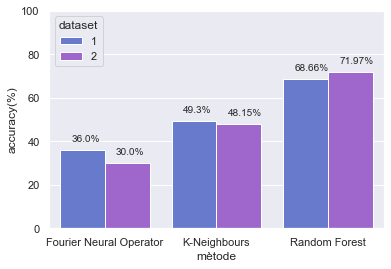

In [247]:
acc = pd.DataFrame()
acc["dataset"] = [1,1,1,2,2,2]
acc["accuracy(%)"] = [36, 49.3, 68.66, 30, 48.15, 71.97]
acc["mètode"] = ["Fourier Neural Operator", "K-Neighbours", "Random Forest", "Fourier Neural Operator", "K-Neighbours", "Random Forest"]
sns.set_palette(sns.color_palette("hls",8)[5:])
b = sns.barplot(x="mètode", y="accuracy(%)", hue="dataset", data=acc)
b.set(ylim=(0, 100))
b.legend(loc='upper left', title="dataset")
for i, bar in enumerate(b.patches[:3]):
    h = bar.get_height()
    b.text(
        i-0.3, # bar index (x coordinate of text)
        h+5, # y coordinate of text
        '{}%'.format(h),  # y label
        ha='left', 
        va='center')
    h = b.patches[3+i].get_height()
    b.text(
        i+0.1, # bar index (x coordinate of text)
        h+5, # y coordinate of text
        '{}%'.format(h),  # y label
        ha='left', 
        va='center')

To conclude, I found pretty fun to use this dataset even though it gave me some hardships. I'm not very happy with the final accuracy because there are some classes that aren't well classified. And well, a downside of the methodology I used would be the execution time I needed for some steps: the feature extraction and the fine tuning took 4hours to finish, which I think is not efficient.